## NLP Class Assignment 6 -- Topic Modeling on News

Richard Yang

You have been provided with a starter notebook that reads a collection of tweets and a collection of news articles about one particular company.  Use appropriate topic modeling technique to identify top N most important topics.  To get quality results apply appropriate text cleaning methods.

- Present top N most important topics in the news articles and tweets
- For news articles, consider how to effectively combine information from the title and text of news article
- Select N to identify relevant topics, but minimize duplication
- Explain how you selected N


In [1]:
import pandas as pd
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import matplotlib as plt

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

print('Python Version: ' + sys.version)
print('TensorFlow Version: ' + tf.__version__)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

c:\Users\Richa\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Python Version: 3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]
TensorFlow Version: 2.12.0


In [2]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# change the bokeh version to 2.4.3

# !pip install bokeh == 2.4.3 --force -reinstall

In [4]:
# import bokeh

# print('Bokeh Version: ' + bokeh.__version__)

In [4]:
path = 'https://storage.googleapis.com/image-bucket-richard/image1'
# read .bmp image file from the path

# !pip install Pillow
from PIL import Image
import requests
from io import BytesIO

response = requests.get(path)

# check tensorflor version
print(tf.__version__)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001D9E0566310>

In [5]:
import ktrain

print('Ktrain Version: ' + ktrain.__version__)4/0AbUR2VPkyhAnJjlBjkUkO4n3sKT7OXGBM3_Bd6vWr3KBMqslg_U7KedctkMTnr6fgmLECw

Ktrain Version: 0.36.0


#### Read news data

In [6]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_6_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 9,962 news articles


,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent..."


LDA on News

In [7]:
# pip install -U gensim

In [8]:
# Load the Drive helper and mount
# from google.colab import drive
# # This will prompt for authorization.
# drive.mount('/content/drive/')
# path_gdrive = '/content/drive/MyDrive/NLP/NLPcode/week6'
# os.chdir(path_gdrive)
# print(os.getcwd())

In [9]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [10]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [11]:
# check the RAM size
!cat /proc/meminfo

'cat' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [12]:
import warnings

# warnings.simplefilter('once')
warnings.simplefilter('ignore')
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [16]:
# Filter non-English articles, apply appropriate cleaning
%time 
news_eng = news_df[news_df['language']=='en'].reset_index(drop=True)
news_eng = news_df['text'].apply(lambda x: re.sub(r'[^\d+\w\s,.]','',x))
news_eng = news_df['text'].apply(lambda x: re.sub(r'\n|\nm|\nm\n\n','',x))

CPU times: total: 0 ns
Wall time: 0 ns


#### Tokenize text into words and remove punctuation

In [17]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = news_eng['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

KeyError: 'text'

#### Remove Stopwords, Make n-grams and Lemmatize

In [20]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 2min 9s, sys: 2.16 s, total: 2min 11s
Wall time: 2min 13s


In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_
         for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 3.07 ms, sys: 27 µs, total: 3.1 ms
Wall time: 3.58 ms


In [ ]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigramsn

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [24]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 24.1 s, sys: 814 ms, total: 24.9 s
Wall time: 25.4 s


#### Build initial 3 topic model

In [25]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

CPU times: user 4min 18s, sys: 23.5 s, total: 4min 42s
Wall time: 5min 37s


In [26]:
# Print the Keyword in the 3 topics
print(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.010*"strip" + 0.008*"height_filesize_mime_type_image" + '
  '0.007*"resize_nbc_cc_file" + 0.006*"resize_width" + '
  '0.006*"jpeg_source_url_https_media" + 0.006*"quality_strip" + '
  '0.006*"pnbcstations_jpg" + 0.004*"say" + '
  '0.003*"com_pnbcstations_jpg_quality" + 0.002*"show"'),
 (1,
  '0.005*"share" + 0.003*"official_music" + 0.002*"news" + 0.002*"stock" + '
  '0.002*"link_open" + 0.002*"make" + 0.002*"get" + 0.002*"post" + '
  '0.002*"open" + 0.002*"company"'),
 (2,
  '0.005*"use" + 0.005*"say" + 0.003*"company" + 0.003*"make" + 0.003*"get" + '
  '0.003*"new" + 0.003*"year" + 0.003*"see" + 0.003*"work" + 0.002*"time"')]


#### Compute Coherence Score

In [27]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3152786736816729
CPU times: user 1min 33s, sys: 415 ms, total: 1min 33s
Wall time: 1min 35s


#### Tune LDA model

In [28]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [29]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [ ]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+2, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
# lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results.csv'), index=False)

LDA will execute 15 iterations


Completed model based on 2 LDA topics. Finished 6.7% of LDA runs
Execution time to calculate for topic 2: 0hour:6min:23sec
Completed model based on 3 LDA topics. Finished 13.3% of LDA runs
Execution time to calculate for topic 3: 0hour:6min:57sec
Completed model based on 4 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 4: 0hour:7min:23sec
Completed model based on 5 LDA topics. Finished 26.7% of LDA runs
Execution time to calculate for topic 5: 0hour:9min:1sec
Completed model based on 6 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 6: 0hour:8min:44sec
Completed model based on 7 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 7: 0hour:9min:29sec
Completed model based on 8 LDA topics. Finished 46.7% of LDA runs
Execution time to calculate for topic 8: 0hour:9min:29sec
Completed model based on 9 LDA topics. Finished 53.3% of LDA runs
Execution time to calculate for topic 9: 0hour:9min:36sec
Completed 

In [31]:
# lda_tuning.to_csv('news_lda_tuning1.csv', index=False)

In [2]:
lda_tuning_news = pd.read_csv('news_lda_tuning1.csv')
lda_tuning_news

,Topics,Alpha,Beta,Coherence
0,2,symmetric,auto,0.299599
1,3,symmetric,auto,0.315279
2,4,symmetric,auto,0.384623
3,5,symmetric,auto,0.368648
4,6,symmetric,auto,0.355163
5,7,symmetric,auto,0.354119
6,8,symmetric,auto,0.356860
7,9,symmetric,auto,0.453795
8,10,symmetric,auto,0.451409
9,11,symmetric,auto,0.430159


In [3]:
# Best LDA parameters
lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
11,13,symmetric,auto,0.532528
13,15,symmetric,auto,0.526518
7,9,symmetric,auto,0.453795
8,10,symmetric,auto,0.451409
14,16,symmetric,auto,0.450790
12,14,symmetric,auto,0.447889
9,11,symmetric,auto,0.430159
10,12,symmetric,auto,0.402913
2,4,symmetric,auto,0.384623
3,5,symmetric,auto,0.368648


In [34]:
# Worst LDA parameters
lda_tuning_news.sort_values(by=['Coherence']).head(10)

,Topics,Alpha,Beta,Coherence
0,2,symmetric,auto,0.299599
1,3,symmetric,auto,0.315279
5,7,symmetric,auto,0.354119
4,6,symmetric,auto,0.355163
6,8,symmetric,auto,0.356860
3,5,symmetric,auto,0.368648
2,4,symmetric,auto,0.384623
10,12,symmetric,auto,0.402913
9,11,symmetric,auto,0.430159
12,14,symmetric,auto,0.447889


### Visualization of Results

<AxesSubplot:title={'center':'LDA Coherence Score For Tweets'}, xlabel='Topics', ylabel='Coherence'>

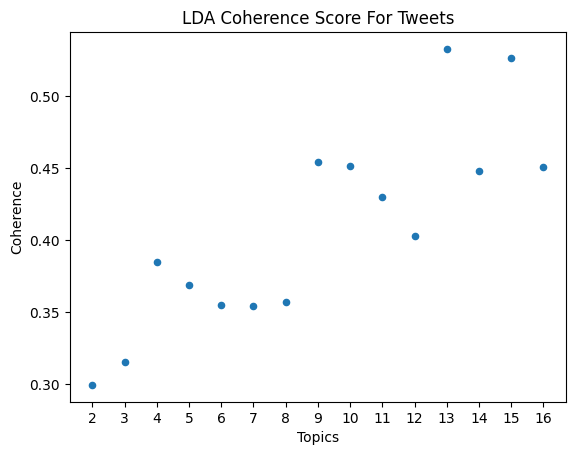

In [4]:
# Scatter plot of LDA coherence scores
lda_tuning_news.plot(x ='Topics', y='Coherence', title = 'LDA Coherence Score For Tweets',kind = 'scatter', xticks=range(2,17))

<AxesSubplot:title={'center':'LDA Coherence Score For Tweets'}, xlabel='Topics'>

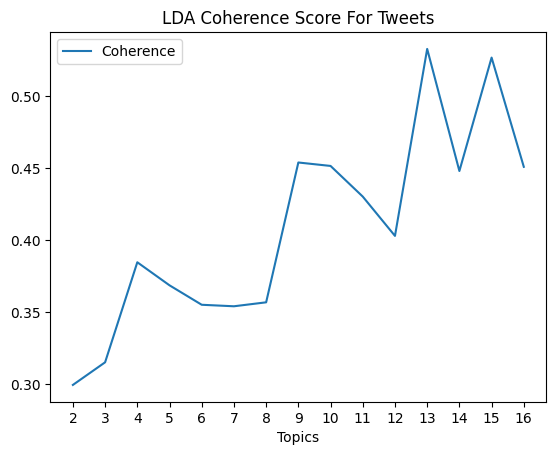

In [5]:
lda_tuning_news.plot(x ='Topics', y='Coherence', title = 'LDA Coherence Score For Tweets',kind = 'line', xticks=range(2,17))

#### Running best model

In [ ]:
sample 100 rows from the data
df_sampleLDA = df_filtered_keywords.sample(n=100, random_state=1)

In [37]:
lda_tuning_best = lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 13, Alpha: symmetric, Beta: auto


In [38]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3152786736816729
CPU times: user 6min 20s, sys: 2min 7s, total: 8min 27s
Wall time: 10min 10s


In [39]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 23.9 s, sys: 12.4 s, total: 36.3 s
Wall time: 1min 24s


### Summary of Results on News

1. According to the coherence score, the best model is the one with **13** topics. The coherence score is 0.5325.

2. Within the **13** topics, the topic 11 is the most important topic. However, this topic might reflect only some common words which may not cotain enough information to tell the overall story here.
However, for the second most important topic, topic 3, it is more informative. It contains words like "company", "market", "stock", "investor", "share", "business", "customer". These words are more informative and can tell it is about the fundamentals and financials of the company.

3. I choose N by hyperparameter tuning. I tried different number of topics and choose the one with the highest coherence score. However, it is neccessary to consider the interpretability of the topics. If the topics are not interpretable, it is not useful to choose the model with the highest coherence score. It is a trade-off between coherence score and interpretability. But in this case, the coherence score and interpretability are both good for the model with **13** topics.

In [6]:
import datetime
import pytz

time = datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")
sign = 'Richard Yang'

print(f'Created at: {time} by {sign}')

Created at: Mon, 01 May 2023 23:02:55 by Richard Yang
